In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import tqdm 
from torch.utils.data import Dataset

class SubsampledDataset(Dataset):
    def __init__(self, dataset, select_classes):
        """
        Wrap an existing dataset to only include samples whose labels are in select_classes.
        Labels are remapped to 0, 1, ..., len(select_classes)-1.
        """
        self.dataset = dataset
        self.select_classes = set(select_classes)
        # Create mapping: original label -> new label (0-indexed)
        self.class_map = {orig_label: new_label 
                          for new_label, orig_label in enumerate(sorted(select_classes))}
        # Filter indices for samples that belong to the desired classes
        self.indices = [i for i, (_, label) in enumerate(dataset) if label in self.select_classes]
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        x, y = self.dataset[actual_idx]
        return x, self.class_map[y]


# --- Hyperparameters ---
batch_size = 1024
lr = 1e-2
epochs = 40
weight_decay_list = [0.0, 1e-4]  # as an example


# Specify which classes to include; for example, only classes 0, 1, and 2.
select_classes = [0, 1, ]

transform = T.Compose([T.ToTensor()])
# Load the full MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
full_test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap the dataset to only include the selected classes
train_dataset = SubsampledDataset(full_train_dataset, select_classes)
test_dataset  = SubsampledDataset(full_test_dataset, select_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of classes
num_classes = 10
# Penultimate dimension, bigger than num_classes
hidden_dim = 512

class Noramalization(nn.Module):
    def __init__(self,):
        super().__init__()
        


# ---- Model Definition with Configurable Activation and Norm ----
class SimpleNet(nn.Module):
    def __init__(self, activation='relu', norm='none', weight_decay=0.0):
        super().__init__()
        
        # Just a simple MLP for demonstration; you can add CNN layers for CIFAR
        self.activation_choice = activation
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'tanh':
            self.act = nn.Tanh()
        elif activation == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation")

        self.norm_choice = norm
        if norm == 'batchnorm':
            norm_layer = nn.BatchNorm1d
        elif norm == 'layernorm':
            norm_layer = nn.LayerNorm
        elif norm == 'none':
            norm_layer = nn.Identity
        else:
            raise ValueError("Unsupported normalization")

        # A small MLP: Flatten -> Dense -> Activation -> Normalization -> Dense -> ...
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.norm1 = norm_layer(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = norm_layer(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, return_penultimate=False):
        x = x.view(x.size(0), -1)
        z = self.fc1(x)
        z = self.norm1(z)
        z = self.act(z)
        z = self.fc2(z)
        z = self.norm2(z)
        z = self.act(z)
        out = self.fc3(z)
        
        if return_penultimate:
            # Return both the final logits and the penultimate features
            return out, z
        return out

# ---- Training loop utility ----
def train_one_variant(activation, norm, weight_decay):
    # Instantiate model
    model = SimpleNet(activation=activation, norm=norm)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train
    model.train()
    for ep in tqdm.trange(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

    # Evaluate classification performance on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    return model, acc

# ---- Extract penultimate layer features and compute rank ----
def analyze_penultimate_features(model):
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            outputs, feats = model(images, return_penultimate=True)
            all_feats.append(feats.cpu())
            all_labels.append(labels)

    all_feats = torch.cat(all_feats, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Compute numerical rank of (N x hidden_dim) features
    # We'll do SVD or rank via torch.linalg.svdvals
    svs = torch.linalg.svdvals(all_feats)
    # For numerical rank, define a threshold e.g. 1e-5 * largest singular value
    threshold = svs.mean().item() * 1e-2
    rank_est = int((svs > threshold).sum().item())

    # Also you can check rank per class, or measure within-class scatter
    # Example: rank across entire dataset
    print("Estimated rank of penultimate features:", rank_est)

    # Optionally compute within-class covariance or scatter
    # for c in range(num_classes):
    #     class_feats = all_feats[all_labels == c]
    #     # Compute variance or some measure for these...
    #     ...

    return rank_est

# ------------- MAIN EXPERIMENT -------------
if __name__ == "__main__":
    for activation in ['relu', 'tanh', 'sigmoid']:
        for norm in ['none', 'batchnorm', 'layernorm']:
            for wd in weight_decay_list:
                model, acc = train_one_variant(activation, norm, wd)
                print(f"Activation={activation}, Norm={norm}, WD={wd}, Test Acc={acc:.2f}")
                rank_est = analyze_penultimate_features(model)
                print(f"Penultimate layer rank={rank_est}")
                print("----------------------------------------------------")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.28it/s]


Activation=relu, Norm=none, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 76
Penultimate layer rank=76
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.29it/s]


Activation=relu, Norm=none, WD=0.0001, Test Acc=99.86
Estimated rank of penultimate features: 146
Penultimate layer rank=146
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


Activation=relu, Norm=batchnorm, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 246
Penultimate layer rank=246
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.28it/s]


Activation=relu, Norm=batchnorm, WD=0.0001, Test Acc=99.67
Estimated rank of penultimate features: 167
Penultimate layer rank=167
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.29it/s]


Activation=relu, Norm=layernorm, WD=0.0, Test Acc=99.91
Estimated rank of penultimate features: 80
Penultimate layer rank=80
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


Activation=relu, Norm=layernorm, WD=0.0001, Test Acc=99.95
Estimated rank of penultimate features: 39
Penultimate layer rank=39
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


Activation=tanh, Norm=none, WD=0.0, Test Acc=99.43
Estimated rank of penultimate features: 3
Penultimate layer rank=3
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


Activation=tanh, Norm=none, WD=0.0001, Test Acc=99.10
Estimated rank of penultimate features: 113
Penultimate layer rank=113
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.28it/s]


Activation=tanh, Norm=batchnorm, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 236
Penultimate layer rank=236
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


Activation=tanh, Norm=batchnorm, WD=0.0001, Test Acc=99.91
Estimated rank of penultimate features: 68
Penultimate layer rank=68
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.29it/s]


Activation=tanh, Norm=layernorm, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 42
Penultimate layer rank=42
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


Activation=tanh, Norm=layernorm, WD=0.0001, Test Acc=99.72
Estimated rank of penultimate features: 34
Penultimate layer rank=34
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


Activation=sigmoid, Norm=none, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 6
Penultimate layer rank=6
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


Activation=sigmoid, Norm=none, WD=0.0001, Test Acc=99.86
Estimated rank of penultimate features: 43
Penultimate layer rank=43
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.25it/s]


Activation=sigmoid, Norm=batchnorm, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 143
Penultimate layer rank=143
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


Activation=sigmoid, Norm=batchnorm, WD=0.0001, Test Acc=99.91
Estimated rank of penultimate features: 134
Penultimate layer rank=134
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


Activation=sigmoid, Norm=layernorm, WD=0.0, Test Acc=99.95
Estimated rank of penultimate features: 50
Penultimate layer rank=50
----------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


Activation=sigmoid, Norm=layernorm, WD=0.0001, Test Acc=99.95
Estimated rank of penultimate features: 11
Penultimate layer rank=11
----------------------------------------------------


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# ------------------------
# Define an optional RMSNorm
# ------------------------
class RMSNorm(nn.Module):
    def __init__(self, d, eps=1e-8):
        super().__init__()
        self.d = d
        self.eps = eps
        # Optional learnable scale (set to 1 by default)
        self.scale = nn.Parameter(torch.ones(d))
    
    def forward(self, x):
        # Compute the root-mean-square along the last dimension
        rms = x.pow(2).mean(dim=-1, keepdim=True).sqrt() + self.eps
        return self.scale * x / rms

# ------------------------
# Define the two-layer model
# ------------------------
class TwoLayerModel(nn.Module):
    def __init__(self, d, C, activation='relu', norm_type=None):
        """
        d: hidden dimension (and input dimension)
        C: number of classes (output dimension)
        activation: 'relu', 'tanh', or 'sigmoid'
        norm_type: None, 'layer_norm', 'batch_norm', or 'rms_norm'
        """
        super().__init__()
        self.d = d
        self.C = C
        self.activation = activation
        self.norm_type = norm_type
        
        # First layer: dxd Gaussian matrix with entries ~ N(0, 1/d)
        self.W1 = nn.Parameter(torch.randn(d, d) / math.sqrt(d))
        
        # Second layer: d x C Gaussian matrix with entries ~ N(0, 1/d^2)
        self.W2 = nn.Parameter(torch.randn(d, C) / d)
        
        # Optional normalization before activation
        if norm_type == 'LN':
            self.norm = nn.LayerNorm(d)
        elif norm_type == 'BN':
            self.norm = nn.BatchNorm1d(d)
        elif norm_type == 'RMS':
            self.norm = RMSNorm(d)
        else:
            self.norm = None

    def forward(self, X):
        # X: (N, d)
        pre_act = X @ self.W1  # (N, d)
        
        # Optionally apply normalization to the pre-activations
        if self.norm is not None:
            pre_act = self.norm(pre_act)
        
        # Apply activation
        if self.activation == 'relu':
            act = F.relu(pre_act)
        elif self.activation == 'tanh':
            act = torch.tanh(pre_act)
        elif self.activation == 'sigmoid':
            act = torch.sigmoid(pre_act)
        else:
            raise ValueError("Unsupported activation")
        
        # Compute logits via the second weight matrix
        logits = act @ self.W2  # (N, C)
        return logits, act, pre_act

# ------------------------
# Experiment Setup
# ------------------------

# Set experiment parameters
N = 5000       # total number of samples
d = 1000       # dimension of each sample (and hidden layer)
C = 10        # number of classes
num_epochs = 400

# Generate N random vectors (each of dimension d)
X = torch.randn(N, d)

# Assign labels: i-th sample has label (i mod C)
labels = torch.tensor([i%C for i in range(N)], dtype=torch.long)

# Choose activation and normalization options
activation = 'relu'         # options: 'relu', 'tanh', 'sigmoid'
norm_type = '‌‌BN'            # options: None, 'layer_norm', 'batch_norm', 'rms_norm'

# Instantiate the model
model = TwoLayerModel(d, C, activation=activation, norm_type=norm_type)

# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def test_model(model, C):
    logits, act, pre_act = model(X)
    M = act
    # M = M - M.mean(dim=1,keepdim=True)
    M = M / (M**2).mean(dim=1,keepdim=True)**0.5
    G = M.T @ M  / N
    svals = torch.linalg.svdvals(G,).detach()
    # plt.plot(svals,marker='.');
    print('top C eigs / total eigs =  ' , (svals[:C].sum()/svals.sum()).item())


# ------------------------
# Training Loop
# ------------------------
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: compute logits
    logits, _, _ = model(X)
    
    # Compute cross-entropy loss
    loss = criterion(logits, labels)
    
    # Backward pass and update
    loss.backward()
    optimizer.step()
    if (epoch)%10==0:
        print(loss.item())
        test_model(model, C)

2.302903413772583
top C eigs / total eigs =   0.3409665822982788
1.7006683349609375
top C eigs / total eigs =   0.35945844650268555
0.6711888909339905
top C eigs / total eigs =   0.38364148139953613
0.11468775570392609
top C eigs / total eigs =   0.3833918869495392
0.021001525223255157
top C eigs / total eigs =   0.3808661997318268
0.00749711599200964
top C eigs / total eigs =   0.3800453543663025
0.0042839329689741135
top C eigs / total eigs =   0.37982437014579773
0.003134742844849825
top C eigs / total eigs =   0.3797539174556732
0.0025819989386945963
top C eigs / total eigs =   0.3797118067741394
0.0022480571642518044
top C eigs / total eigs =   0.3796693980693817
0.0020098956301808357
top C eigs / total eigs =   0.379621297121048
0.0018214788287878036
top C eigs / total eigs =   0.37956860661506653
0.0016637679655104876
top C eigs / total eigs =   0.3795127868652344
0.001527746906504035
top C eigs / total eigs =   0.3794545531272888
0.0014085641596466303
top C eigs / total eigs = 

tensor([[ 1.0092, -0.0137, -0.0688, -0.0395,  0.0074],
        [-0.0137,  1.0250, -0.0665, -0.0482, -0.0313],
        [-0.0688, -0.0665,  1.0392,  0.0471, -0.0036],
        [-0.0395, -0.0482,  0.0471,  0.9722,  0.0149],
        [ 0.0074, -0.0313, -0.0036,  0.0149,  0.9994]],
       grad_fn=<SliceBackward0>)

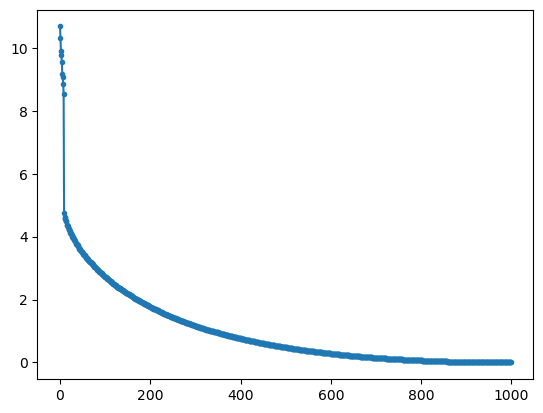

In [3]:
logits, act, pre_act = model(X)
M = pre_act
# M = M - M.mean(dim=1,keepdim=True)
M = M / (M**2).mean(dim=1,keepdim=True)**0.5
G = M.T @ M  / N
svals = torch.linalg.svdvals(G,).detach()
plt.plot(svals,marker='.');
svals[:10].sum()/svals.sum()


G[:5,:5]
# plt.imshow(G[:5,:5].detach())
# plt.colorbar()

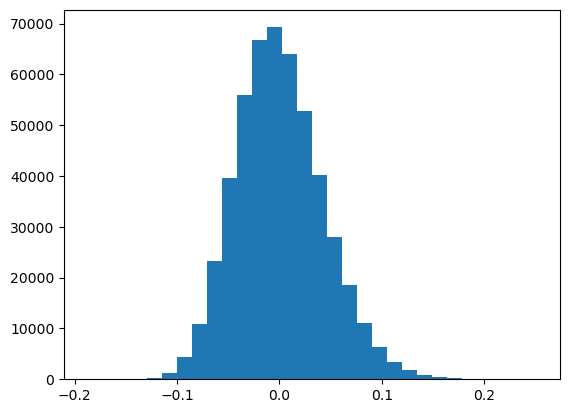

In [4]:
G_flat = torch.triu(G.detach(), diagonal=1).flatten()
G_flat = G_flat[G_flat!=0]
plt.hist(G_flat,bins=30);

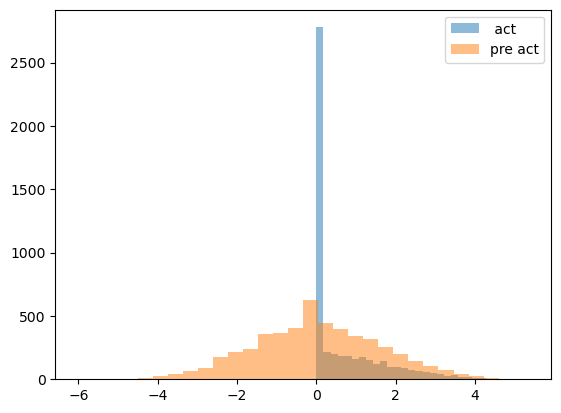

In [8]:
import matplotlib.pyplot as plt
import numpy as np
f = 1
plt.hist(act[:,f].detach(),label=' act',alpha=0.5,bins=30)
plt.hist(pre_act[:,f].detach(),label='pre act',alpha=0.5,bins=30)
plt.legend();

In [7]:
act.shape

torch.Size([5000, 1000])

In [185]:
torch.linalg.svdvals(G,).detach()

tensor([3.0583e+01, 2.9076e+01, 2.7079e+01, 2.5391e+01, 2.4546e+01, 2.4120e+01,
        2.3484e+01, 2.1080e+01, 1.9404e+01, 1.1915e+01, 5.5937e+00, 5.4528e+00,
        5.2881e+00, 5.2259e+00, 5.0046e+00, 4.9929e+00, 4.8882e+00, 4.7590e+00,
        4.6955e+00, 4.5629e+00, 4.4675e+00, 4.4192e+00, 4.3149e+00, 4.3064e+00,
        4.2440e+00, 4.1676e+00, 4.0469e+00, 3.9413e+00, 3.9080e+00, 3.8549e+00,
        3.8205e+00, 3.7708e+00, 3.7543e+00, 3.6888e+00, 3.6612e+00, 3.6120e+00,
        3.6008e+00, 3.5695e+00, 3.4890e+00, 3.4282e+00, 3.4051e+00, 3.3510e+00,
        3.3082e+00, 3.2907e+00, 3.2697e+00, 3.2335e+00, 3.2221e+00, 3.1804e+00,
        3.1321e+00, 3.1235e+00, 3.1207e+00, 3.0751e+00, 3.0063e+00, 2.9779e+00,
        2.9564e+00, 2.9178e+00, 2.9133e+00, 2.9084e+00, 2.8684e+00, 2.8448e+00,
        2.8214e+00, 2.7903e+00, 2.7766e+00, 2.7568e+00, 2.7521e+00, 2.7365e+00,
        2.7068e+00, 2.6798e+00, 2.6720e+00, 2.6498e+00, 2.6478e+00, 2.6242e+00,
        2.6179e+00, 2.6041e+00, 2.5871e+